# Meteorological data

Gets AORC data for the domain and time period.

In [1]:
%matplotlib ipympl

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
# setting up logging first or else it gets preempted by another package
import watershed_workflow.ui
watershed_workflow.ui.setup_logging(1)

In [4]:
import os,sys
import logging
import numpy as np
from matplotlib import pyplot as plt
import pickle
import shapely
import pandas as pd
import geopandas as gpd
import xarray as xr
pd.options.display.max_columns = None

import cftime

import watershed_workflow 
import watershed_workflow.config
import watershed_workflow.sources
import watershed_workflow.mesh
import watershed_workflow.regions
import watershed_workflow.meteorology
import watershed_workflow.io

# set the default figure size for notebooks
plt.rcParams["figure.figsize"] = (8, 6)

## Input: Parameters and other source data

In [5]:
# Force Watershed Workflow to pull data from this directory rather than a shared data directory.
# This picks up the Coweeta-specific datasets set up here to avoid large file downloads for 
# demonstration purposes.
#
def splitPathFull(path):
    """
    Splits an absolute path into a list of components such that
    os.path.join(*splitPathFull(path)) == path
    """
    parts = []
    while True:
        head, tail = os.path.split(path)
        if head == path:  # root on Unix or drive letter with backslash on Windows (e.g., C:\)
            parts.insert(0, head)
            break
        elif tail == path:  # just a single file or directory
            parts.insert(0, tail)
            break
        else:
            parts.insert(0, tail)
            path = head
    return parts

cwd = splitPathFull(os.getcwd())
assert cwd[-1] == 'workflow'
cwd = cwd[:-1]

# Note, this directory is where downloaded data will be put as well
data_dir = os.path.join(*(cwd + ['input_data',]))
def toInput(filename):
    return os.path.join(data_dir, filename)

output_dir = os.path.join(*(cwd + ['output_data',]))
output_filenames = dict()
def fromOutput(filename):
    return os.path.join(output_dir, filename)    

def toOutput(role, filename):
    output_filenames[role] = filename
    return fromOutput(filename)

# check output and input dirs exist
if not os.path.isdir(data_dir):
    os.makedirs(data_dir, exist_ok=True)
if not os.path.isdir(output_dir):
    os.makedirs(output_dir, exist_ok=True)
       

In [6]:
# Set the data directory to the local space to get the locally downloaded files
# REMOVE THIS CELL for general use outside fo Coweeta
watershed_workflow.config.setDataDirectory(data_dir)


In [7]:
## Parameters cell -- this provides all parameters that can be changed via pipelining to generate a new watershed. 
name = 'RussianRiver'
hucs = ['18010110'] # a list of HUCs to run

# Geometric parameters
# -- parameters to clean and reduce the river network prior to meshing
prune_by_area = 10               # km^2
simplify = 125                   # length scale to target average edge 

# -- mesh triangle refinement control
refine_d0 = 200
refine_d1 = 600

refine_L0 = 125
refine_L1 = 300

refine_A0 = refine_L0**2 / 2
refine_A1 = refine_L1**2 / 2

# Refine triangles if they get too acute
min_angle = 20 # degrees

# width of reach by stream order (order:width)
river_widths = dict({1:10, 2:10, 3:20, 4:30, 5:30}) 


# Note that, by default, we tend to work in the DayMet CRS because this allows us to avoid
# reprojecting meteorological forcing datasets.
crs = watershed_workflow.crs.default_crs

# start and stop time for simulation
# note that this is the overlap of AORC and MODIS
start = cftime.DatetimeGregorian(2007, 8, 1)
end = cftime.DatetimeGregorian(2020, 7, 31)

start_noleap = cftime.DatetimeNoLeap(2007, 8, 1)
end_noleap = cftime.DatetimeNoLeap(2020, 7, 31)
cyclic_nyears = 10



In [8]:
# set up a dictionary of source objects
#
# Data sources, also called managers, deal with downloading and parsing data files from a variety of online APIs.
sources = watershed_workflow.sources.getDefaultSources()

# log the sources that will be used here
watershed_workflow.sources.logSources(sources)


2025-10-07 14:52:43,098 - root - INFO: Using sources:
2025-10-07 14:52:43,099 - root - INFO: --------------
2025-10-07 14:52:43,099 - root - INFO: HUC: WBD
2025-10-07 14:52:43,099 - root - INFO: hydrography: NHDPlus MR v2.1
2025-10-07 14:52:43,099 - root - INFO: DEM: 3DEP 60m
2025-10-07 14:52:43,099 - root - INFO: soil structure: National Resources Conservation Service Soil Survey (NRCS Soils)
2025-10-07 14:52:43,099 - root - INFO: geologic structure: shapefile: "GLHYMPS.shp"
2025-10-07 14:52:43,099 - root - INFO: land cover: NLCD 2021 L48
2025-10-07 14:52:43,100 - root - INFO: LAI: MODIS
2025-10-07 14:52:43,100 - root - INFO: depth to bedrock: raster: "average_soil_and_sedimentary-deposit_thickness.tif"
2025-10-07 14:52:43,101 - root - INFO: meteorology: AORC v1.1


## Reload data

In [9]:
with open(fromOutput('02_watersheds.pickle'), 'rb') as fid:
    watersheds = pickle.load(fid)

## Download AORC

In [10]:
# download the data, including:
#  - lazy spatial subsetting to the watershed
#  - chunked temporal_resampling to daily data
#  - streamed directly to file
met_data_request = sources['meteorology'].requestDataset(watersheds.exterior, crs, start, end, temporal_resampling='1D')

time_chunk_size = 100
met_data_chunked = sources['meteorology'].fetchRequest(met_data_request, chunk_time=time_chunk_size)


2025-10-07 14:52:43,211 - root - INFO: Incoming shape area = 0.39872864798547364
2025-10-07 14:52:43,211 - root - INFO: ... buffering incoming shape by = 0.00833333
2025-10-07 14:52:43,214 - root - INFO: ... buffered shape area = 0.4350579068389571
2025-10-07 14:52:43,214 - root - INFO:   Using existing: /home/ecoon/research/HypeRFACETs/PacWest-RDT/RussianRiver/input_data/meteorology/aorc/aorc_2007-2020_39.4073x-122.5213-38.2909x-123.3959_1D.nc


In [11]:
# aorc is a lat-lon product -- project it
met_data_projected = watershed_workflow.warp.dataset(met_data_chunked, crs, 'bilinear', time_chunk_size, toOutput('warped meterology', 'warped_meteorology.nc'))


/home/ecoon/code/miniforge3/envs/ww-geopandas-20250725/lib/python3.13/site-packages/zarr/api/asynchronous.py:228: UserWarning: Consolidated metadata is currently not part in the Zarr format 3 specification. It may not be supported by other zarr implementations and may change in the future.
  warnings.warn(
/home/ecoon/code/miniforge3/envs/ww-geopandas-20250725/lib/python3.13/site-packages/zarr/api/asynchronous.py:228: UserWarning: Consolidated metadata is currently not part in the Zarr format 3 specification. It may not be supported by other zarr implementations and may change in the future.
  warnings.warn(
/home/ecoon/code/miniforge3/envs/ww-geopandas-20250725/lib/python3.13/site-packages/zarr/api/asynchronous.py:228: UserWarning: Consolidated metadata is currently not part in the Zarr format 3 specification. It may not be supported by other zarr implementations and may change in the future.
  warnings.warn(
/home/ecoon/code/miniforge3/envs/ww-geopandas-20250725/lib/python3.13/site-p

In [12]:
met_data_projected['time']


<xarray.DataArray 'time' (time: 4749)> Size: 38kB
array(['2007-08-01T00:00:00.000000000', '2007-08-02T00:00:00.000000000',
       '2007-08-03T00:00:00.000000000', ..., '2020-07-29T00:00:00.000000000',
       '2020-07-30T00:00:00.000000000', '2020-07-31T00:00:00.000000000'],
      shape=(4749,), dtype='datetime64[ns]')
Coordinates:
  * time         (time) datetime64[ns] 38kB 2007-08-01 2007-08-02 ... 2020-07-31
    spatial_ref  int64 8B ...

In [13]:
met_data_transient = watershed_workflow.meteorology.convertAORCToATS(met_data_projected)


2025-10-07 14:56:03,413 - root - INFO: Converting AORC to ATS met input


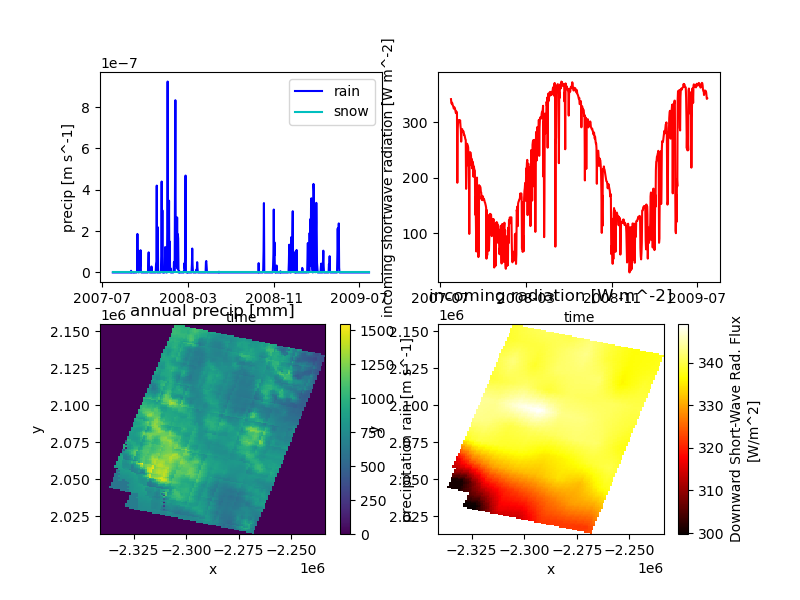

In [14]:
# plot a few of the met data -- does it look reasonable?
def plotMetData(met, x=5, y=5):
    """plot one pixel as a function of time"""
    fig = plt.figure()
    ax = fig.add_subplot(221)
    
    met_data_single_pixel = met.isel({'time':slice(0,365*2),
                                               'x' : x,
                                               'y' : y})
    
    met_data_single_pixel['precipitation rain [m s^-1]'].plot(color='b', label='rain')
    met_data_single_pixel['precipitation snow [m SWE s^-1]'].plot(color='c', label='snow')
    ax.set_ylabel('precip [m s^-1]')
    ax.set_title('')
    ax.legend()
    
    ax = fig.add_subplot(222)
    met_data_single_pixel['incoming shortwave radiation [W m^-2]'].plot(color='r', label='qSW_in')
    ax.set_ylabel('incoming shortwave radiation [W m^-2]')
    ax.set_title('')

    ax = fig.add_subplot(223)
    (met['precipitation rain [m s^-1]'][0:365].sum(axis=0)*86400*1000).plot.imshow()
    ax.set_title('annual precip [mm]')

    ax = fig.add_subplot(224)
    met['incoming shortwave radiation [W m^-2]'][0].plot.imshow(cmap='hot')
    ax.set_title('incoming radiation [W m^-2]')

    
    plt.show()

plotMetData(met_data_transient, 50,50)

In [15]:
met_data_transient['time'][0:3]

<xarray.DataArray 'time' (time: 3)> Size: 24B
array([cftime.DatetimeGregorian(2007, 8, 1, 0, 0, 0, 0, has_year_zero=False),
       cftime.DatetimeGregorian(2007, 8, 2, 0, 0, 0, 0, has_year_zero=False),
       cftime.DatetimeGregorian(2007, 8, 3, 0, 0, 0, 0, has_year_zero=False)],
      dtype=object)
Coordinates:
  * time         (time) object 24B 2007-08-01 00:00:00 ... 2007-08-03 00:00:00
    spatial_ref  int64 8B ...

In [16]:
met_data_transient

<xarray.Dataset> Size: 6GB
Dimensions:                                (y: 165, x: 125, time: 4749)
Coordinates:
  * y                                      (y) float64 1kB 2.154e+06 ... 2.01...
  * x                                      (x) float64 1kB -2.341e+06 ... -2....
  * time                                   (time) object 38kB 2007-08-01 00:0...
    spatial_ref                            int64 8B ...
Data variables:
    air temperature [K]                    (time, y, x) float64 784MB dask.array<chunksize=(100, 165, 125), meta=np.ndarray>
    incoming shortwave radiation [W m^-2]  (time, y, x) float64 784MB dask.array<chunksize=(100, 165, 125), meta=np.ndarray>
    incoming longwave radiation [W m^-2]   (time, y, x) float64 784MB dask.array<chunksize=(100, 165, 125), meta=np.ndarray>
    vapor pressure air [Pa]                (time, y, x) float64 784MB dask.array<chunksize=(100, 165, 125), meta=np.ndarray>
    wind speed [m s^-1]                    (time, y, x) float64 784MB dask.array<chunksize=(100, 165, 125), meta=np.ndarray>
    precipitation total [m s^-1]           (time, y, x) float64 784MB dask.array<chunksize=(100, 165, 125), meta=np.ndarray>
    precipitation rain [m s^-1]            (time, y, x) float64 784MB dask.array<chunksize=(100, 165, 125), meta=np.ndarray>
    precipitation snow [m SWE s^-1]        (time, y, x) float64 784MB dask.array<chunksize=(100, 165, 125), meta=np.ndarray>
Attributes:
    wind speed reference height [m]:  10.0

In [17]:
# write transient data to disk
filename = toOutput('meteorology_transient', f'{name}_aorc-{start.year}-{end.year}.h5')
watershed_workflow.io.writeDatasetToHDF5(
    filename,
    met_data_transient
    )

2025-10-07 14:56:04,237 - root - INFO: Writing HDF5 file: /home/ecoon/research/HypeRFACETs/PacWest-RDT/RussianRiver/output_data/RussianRiver_aorc-2007-2020.h5


In [18]:
# compute the typical year
met_data_typical = watershed_workflow.meteorology.computeTypicalYear(met_data_transient, cyclic_nyears)


2025-10-07 14:57:02,685 - root - INFO: Computing a typical year.


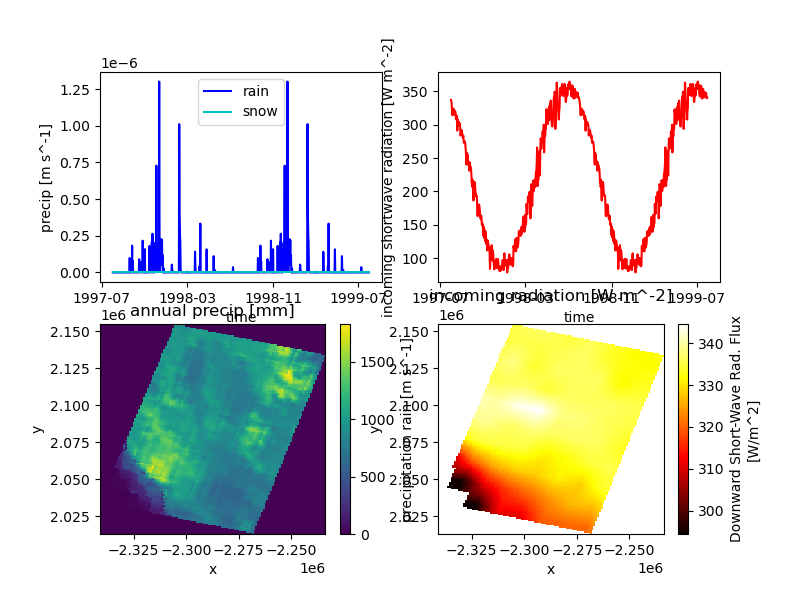

In [19]:
plotMetData(met_data_typical, 50, 50)

In [20]:
# write typical data to disk
filename = toOutput('meteorology_typical', f'{name}_aorc_typical-{start.year-cyclic_nyears}-{start.year}.h5')
watershed_workflow.io.writeDatasetToHDF5(
    filename,
    met_data_typical
    )

2025-10-07 14:57:43,681 - root - INFO: Writing HDF5 file: /home/ecoon/research/HypeRFACETs/PacWest-RDT/RussianRiver/output_data/RussianRiver_aorc_typical-1997-2007.h5


In [21]:
# also save an average P - ET = 0.6 * average P
pavg = met_data_transient['precipitation rain [m s^-1]'].mean()

with open(toOutput('total_avg_precip', 'total_avg_precip.pickle'), 'wb') as fid:
    pickle.dump(float(pavg.values), fid)


In [22]:
# lastly, reread, update, and output filenames
with open(toOutput('05_output_filenames', '05_output_filenames.txt'), 'wb') as fid:
    pickle.dump(output_filenames, fid)